In [2]:
import numpy as np
import pandas as pd
from konlpy.tag import Okt
import re

C:\Users\qls05\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
df = pd.read_csv(r"C:\Users\qls05\OneDrive\바탕 화면\sos.csv", encoding = 'cp949')
df.head()

,연,월,일,시,분,수신지역,송출내용,target
0,2020,1,26,9,9,중구,[중구청] 오늘 07:00경 중구 장충동 앰버서더호텔 내 화재 발생. 이 지역을 우...,기타
1,2020,1,28,16,59,광진구,[광진구청] 신종 코로나바이러스감염증 예방수칙 마스크 착용 흐르는물 30초이상 손씻...,전염병
2,2020,1,30,9,49,송파구,[송파구청]감염증 대응을 위해 구청장 중심으로 24시간 대책본부를 운영하고 있습니다...,전염병
3,2020,1,31,14,31,강남구,"[강남구]중국 방문 후 14일 이내에 발열(37.5도 이상) 또는 호흡기증상(기침,...",전염병
4,2020,1,31,15,5,강남구,"[강남구]중국 방문 후 14일이내에 발열(37.5도이상) 또는 호흡기증상(기침,인후...",전염병


In [4]:
# 클러스터링을 위해 송출내용 제외하고 모두 제거
df = df.drop(columns=['연', '월', '일', '시', '분', '수신지역', 'target'])
df.head()

,송출내용
0,[중구청] 오늘 07:00경 중구 장충동 앰버서더호텔 내 화재 발생. 이 지역을 우...
1,[광진구청] 신종 코로나바이러스감염증 예방수칙 마스크 착용 흐르는물 30초이상 손씻...
2,[송파구청]감염증 대응을 위해 구청장 중심으로 24시간 대책본부를 운영하고 있습니다...
3,"[강남구]중국 방문 후 14일 이내에 발열(37.5도 이상) 또는 호흡기증상(기침,..."
4,"[강남구]중국 방문 후 14일이내에 발열(37.5도이상) 또는 호흡기증상(기침,인후..."


In [5]:
import re

# 정규 표현식 패턴 설정
pattern = r'\[[^\]]+\]'

# 정규 표현식을 사용하여 패턴을 찾아서 삭제
df['송출내용'] = df['송출내용'].apply(lambda x: re.sub(pattern, '', x))

df.head()

,송출내용
0,오늘 07:00경 중구 장충동 앰버서더호텔 내 화재 발생. 이 지역을 우회하여 주...
1,신종 코로나바이러스감염증 예방수칙 마스크 착용 흐르는물 30초이상 손씻기 중국방문...
2,감염증 대응을 위해 구청장 중심으로 24시간 대책본부를 운영하고 있습니다. 확진자는...
3,"중국 방문 후 14일 이내에 발열(37.5도 이상) 또는 호흡기증상(기침,인후통 등..."
4,"중국 방문 후 14일이내에 발열(37.5도이상) 또는 호흡기증상(기침,인후통등) 발..."


## 불용어 제거

In [6]:
# 불용어 사전 불러오기

# 한글 불용어 사전 파일 경로
stopwords_path = r'C:\Users\qls05\OneDrive\바탕 화면\stopwords-ko.txt'

# 파일 읽기
with open(stopwords_path, "r", encoding="utf-8") as file:
    stopwords = file.readlines()

# 각 불용어의 좌우 공백과 개행문자 제거
stopwords = [word.strip() for word in stopwords]
# 추가 불용어
stopwords.extend(['[', ']'])

In [7]:
# 불용어 처리

# Okt 형태소 분석기 생성
okt = Okt()

# 특수 단어 리스트 정의
special_words = ['확진자', '서울의료원']

# 텍스트 전처리 함수 정의
def preprocess_text_korean(text):
    # 특수 문자 제거
    text = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣\s]', '', text)

    # 형태소 분석 및 불용어 제거
    tokens = okt.pos(text, stem=True)

    # 명사와 동사/형용사만 남기기 및 불용어 제거
    tokens = [word for word, pos in tokens if pos in ['Noun', 'Verb', 'Adjective'] and word not in stopwords]

    # 특정 단어들을 하나의 토큰으로 결합
    for special_word in special_words:
        while special_word in tokens:
            index = tokens.index(special_word)
            tokens[index:index + len(special_word)] = [special_word]

    # 토큰을 다시 문자열로 합침
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# '송출내용' 열에 전처리 적용
df['preprocessed_송출내용'] = df['송출내용'].apply(preprocess_text_korean)

# 변경된 내용을 확인하기 위해 데이터프레임의 처음 몇 행 출력
df[['송출내용', 'preprocessed_송출내용']].head(10)


,송출내용,preprocessed_송출내용
0,오늘 07:00경 중구 장충동 앰버서더호텔 내 화재 발생. 이 지역을 우회하여 주...,오늘 경 중구 장충동 앰버 서다 호텔 내 화재 발생 지역 우회 하다 주시 인근 주민...
1,신종 코로나바이러스감염증 예방수칙 마스크 착용 흐르는물 30초이상 손씻기 중국방문...,신종 코로나바이러스 감염증 예방 칙 마스크 착용 흐르다 물 초이 손씻기 중국 방문 ...
2,감염증 대응을 위해 구청장 중심으로 24시간 대책본부를 운영하고 있습니다. 확진자는...,감염증 대응 위해 청장 중심 대책 본부 운영 확 진자 없다 발열 증상 시 보건소 문...
3,"중국 방문 후 14일 이내에 발열(37.5도 이상) 또는 호흡기증상(기침,인후통 등...",중국 방문 후 이내 발열 호흡기 증상 기침 후통 발 현시 강남구 재난 안전 대책 부...
4,"중국 방문 후 14일이내에 발열(37.5도이상) 또는 호흡기증상(기침,인후통등) 발...",중국 방문 후 내 발열 호흡기 증상 기침 후통 발현 시 강남구 재난 안전 대책 부로...
5,은평성모병원환자코로나19추가확진자발생.성모병원부분일시폐쇄.발열호흡기증상시1339 또...,은평 병원 환자 코로나 추가 확 진자 발생 성모 병원 부분 일시 폐쇄 발열 호흡기 ...
6,"코로나19 2번째 확진자 발생. 성내동 거주 66세(중국인), 2.24. 확진판정,...",코로나 확 진자 발생 성내동 거주 중국인 확진 판정 흑석동 중대 병원 격리 자세하다...
7,"코로나19 확진자 2명 추가 발생, 23일 문정동 확진자의 가족으로 서울의료원에 ...",코로나 확 진자 명 추가 발생 문정동 확 진자 가족 의료 격리 조치 하다 자세하다 ...
8,"금일코로나19확진추가2명발생,2.1부터은평성모병원입퇴원주민중발열 호흡기증상시보건소0...",금일 코로나 확진 추가 발생 은평 성모 병원 입 퇴원 주민 발열 호흡기 증상 보건소...
9,"코로나19 확진자 2명 추가 발생, 자세한내용은 강동구 홈페이지를 참고 바랍니다.",코로나 확 진자 명 추가 발생 자세하다 내용 강동구 홈페이지 참고 바라다


In [8]:
# 전처리된 송출내용만 남긴 데이터프레임: new_df
new_df = df.drop(columns=['송출내용'])
new_df.head()

,preprocessed_송출내용
0,오늘 경 중구 장충동 앰버 서다 호텔 내 화재 발생 지역 우회 하다 주시 인근 주민...
1,신종 코로나바이러스 감염증 예방 칙 마스크 착용 흐르다 물 초이 손씻기 중국 방문 ...
2,감염증 대응 위해 청장 중심 대책 본부 운영 확 진자 없다 발열 증상 시 보건소 문...
3,중국 방문 후 이내 발열 호흡기 증상 기침 후통 발 현시 강남구 재난 안전 대책 부...
4,중국 방문 후 내 발열 호흡기 증상 기침 후통 발현 시 강남구 재난 안전 대책 부로...


## TF-IDF

In [9]:
# TF-IDF 벡터라이저 생성
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=100) # (max_features=100) // max_features는 필요에 따라 조정 가능
tfidf_matrix = vectorizer.fit_transform(new_df['preprocessed_송출내용']) # 텍스트 데이터를 학습 및 변환

print(tfidf_matrix.shape)
tfidf_matrix

# tfidf_matrix는 (문서 수*단어 수)의 행렬. 단어 수는 max_features=1000으로 지정함
# 행렬의 값은 각 문서에서 해당 단어의 중요도(TF-IDF값)을 나타낸 것

(9348, 100)


<9348x100 sparse matrix of type '<class 'numpy.float64'>'
	with 87476 stored elements in Compressed Sparse Row format>

In [10]:
tfidf_dense = tfidf_matrix.toarray()
tfidf_dense.shape

(9348, 100)

**데이터 스케일링**

In [11]:
from sklearn.preprocessing import StandardScaler

# 데이터 스케일링 (거리 기반 클러스터링에 스케일링 필요)
scaler = StandardScaler(with_mean=False)  # TF-IDF는 sparse matrix이므로 with_mean=False 설정
scaled_tfidf = scaler.fit_transform(tfidf_matrix)

In [12]:
# scaled_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
# scaled_tfidf.head(5)

# ----------------------------

# k-means 분류 시작

In [13]:
! pip install threadpoolctl==3.1.0

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [14]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### 1. 모델 생성 및 학습

In [15]:
# KMeans 모델 생성 및 학습
kmeans = KMeans(n_clusters=10, random_state=42)  # 클러스터 개수를 적절히 설정
kmeans.fit(tfidf_dense)

C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=10, random_state=42)

In [16]:
#레이블 추출
kmeans_labels = kmeans.labels_

### 2. pca를 활용한 2차원축소 및 시각화

In [17]:
from sklearn.decomposition import PCA

In [18]:
from sklearn.decomposition import PCA

# PCA로 2차원 축소
pca = PCA(n_components=2)
pca_results = pca.fit_transform(tfidf_dense)


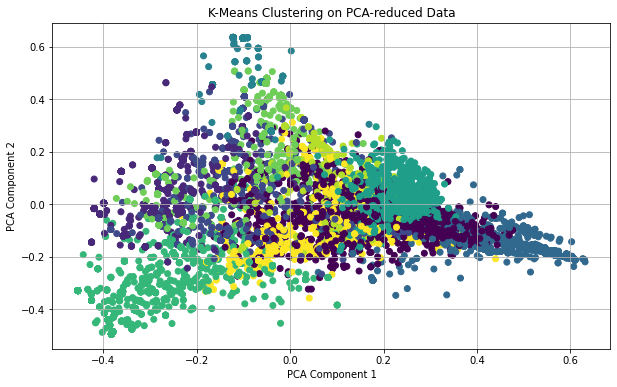

In [19]:
import matplotlib.pyplot as plt

# PCA 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('K-Means Clustering on PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

### 3. hyperparameter 조정하기

In [45]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 하이퍼파라미터 범위 설정
n_clusters_range = [10,15,20,25, 30]
init_methods = ['k-means++', 'random']

# 최적의 파라미터를 저장할 변수 초기화
best_score = -1
best_params = {}

# 모든 하이퍼파라미터 조합을 탐색
for n_clusters in n_clusters_range:
    for init in init_methods:
                kmeans = KMeans(n_clusters=n_clusters, init=init, random_state=42)
                cluster_labels = kmeans.fit(tfidf_dense)
                labels = kmeans.labels_
                centroids = kmeans.cluster_centers_
                score = silhouette_score(tfidf_dense, labels)
                
                if score > best_score:
                    best_score = score
                    best_params = {
                        'n_clusters': n_clusters,
                        'init': init,
                    }

print("Best parameters found: ", best_params)
print("Best silhouette score: ", best_score)

C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

Best parameters found:  {'n_clusters': 30, 'init': 'k-means++'}
Best silhouette score:  0.23853242790478774


**시각화**

C:\Users\qls05\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


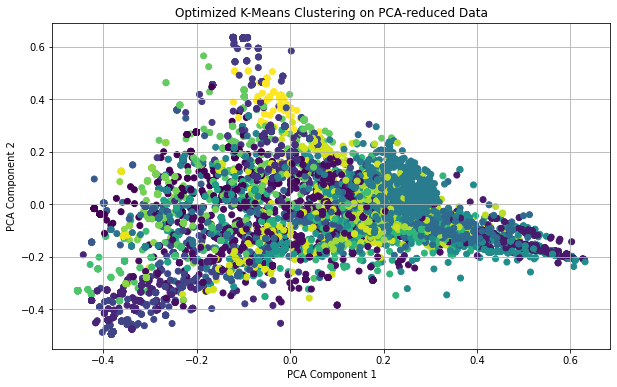

In [48]:
# 최적의 파라미터로 K-Means 모델 학습
kmeans = KMeans(**best_params, random_state=42)
kmeans.fit(tfidf_dense)
kmeans_labels = kmeans.labels_

# PCA로 2차원 축소
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(tfidf_dense)

# PCA 결과 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=kmeans_labels, cmap='viridis', marker='o')
plt.title('Optimized K-Means Clustering on PCA-reduced Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()


### 4. 키워도 도출

In [52]:
# 클러스터 중심을 데이터프레임으로 변환
centroids_df = pd.DataFrame(centroids, columns=df.columns)

# 각 클러스터의 주요 피처 확인
top_features = {}
for i, centroid in centroids_df.iterrows():
    top_features[i] = centroid.sort_values(ascending=False).head(10).index.tolist()

# 결과 출력
for cluster, features in top_features.items():
    print(f"Cluster {cluster}: {', '.join(features)}")

ValueError: Shape of passed values is (30, 100), indices imply (30, 2)